# Second Model (`registered` and `casual` separately)

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
plt.style.use('dark_background')
import subprocess
%config IPCompleter.use_jedi = False

In [2]:
## Hyperparameters

validDays = 17
minLeafSamp = 1
trainEpochs1_r = 10
trainEpochs2_r = 10
trainEpochs1_c = 15
trainEpochs2_c = 10
layer1 = 200
layer2 = 100
layer3 = 50

In [3]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [4]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [5]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [6]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [7]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [8]:
df     = pd.read_csv(path/'train.csv', low_memory=False)
dfTest = pd.read_csv(path/'test.csv', low_memory=False)

In [9]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [10]:
dfTest.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

Let's save the original `datetime` column of the test set because we'll need it for when we print the submission files with the test set predictions,

In [11]:
datetimeTest = dfTest['datetime']
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

#### Handle ordinal columns (non-numeric)

There arent any...

In [12]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

The metric that they want us to use is RMSLE (root mean square log error) to do this we can convert the dependent variable `counts`/`registered`/`casual` into `log(count)` etc. and then use RMSE as our metric which is already built in.

In [13]:
depVar   = 'count'
depVar_r = 'registered'
depVar_c = 'casual'

In [14]:
df[depVar]   = np.log(df[depVar]   + 1)
df[depVar_r] = np.log(df[depVar_r] + 1)
df[depVar_c] = np.log(df[depVar_c] + 1)

The stated loss function for this competition (root mean squared log error, RMSLE) is given as:

$$
RMSLE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(t_i+1))^2 }
$$


The above cell substitutes the targets $t_i$ for $\log(t_i + 1)$. Our models will be predicting $p_i$ from RMSE,

$$
RMSE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (p_i - t_i)^2 }
$$

So to turn the predictions back into counts we just have to exponentiate and subtract 1,

$$
\begin{align}
    \log(p_i+1) &= p_i \\
    e^{\log(p_i + 1)} &= e^{p_i} \\
    p_i &= e^{p_i} - 1
\end{align}
$$

So since our model predicts $p_i$ which is equal to $\log(p_i+1)$ we don't have to worry about the $+1$ in the prediction. Our model is predicting $\log(p_i+1)$ directly because the input target is $\log(t_i+1)$, to convert our prediciton into counts we just exponentiate and subtract 1.

For the second model we'll be predicting `registered` and `casual` separately using their own dataframes respectively. Then summing those predictions to get `count`, so we'll drop `count` for now,

In [15]:
df_r = df.drop(columns=[depVar, depVar_c])
df_c = df.drop(columns=[depVar, depVar_r])
df_r.columns, df_c.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'registered'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual'],
       dtype='object'))

### Handle dates

Change the `datetime` column into a bunch of component info with `add_datepart()` and include the `time`. 

In [16]:
df     = add_datepart(df, 'datetime', time=True)
df_r   = add_datepart(df_r, 'datetime', time=True)
df_c   = add_datepart(df_c, 'datetime', time=True)
dfTest = add_datepart(dfTest, 'datetime', time=True)

In [17]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

### Using TabularPandas and TabularProc

In [18]:
df_r.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'registered', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [19]:
dfTest.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [20]:
for col in df_r.columns:
    print(col, ':', df_r[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52  49  48  37  33  28  38  36  93  29 

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [21]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 2 days of each month in the training set, i.e. 18th--19th of each month.

In [22]:
cond = (df_r.datetimeDay>=validDays)
trainIdx = np.where(~cond)[0]
validIdx = np.where( cond)[0]

splits = (list(trainIdx), list(validIdx))

In [23]:
cont,cat = cont_cat_split(df_r, max_card=18, dep_var=depVar_r)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeHour',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start',
  'datetimeMinute',
  'datetimeSecond'])

In [24]:
to_r = TabularPandas(df_r, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_r, 
                   splits=splits)

to_c = TabularPandas(df_c, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_c, 
                   splits=splits)

to = TabularPandas(df, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar, 
                   splits=splits)

toTest = TabularPandas(dfTest, 
                       procs=procs, 
                       cat_names=cat, 
                       cont_names=cont, 
                       splits=None)

In [25]:
print('registered: ', len(to_r.train), len(to_r.valid))
print('casual:     ', len(to_c.train), len(to_c.valid))
print('test:       ', len(toTest))

registered:  9174 1712
casual:      9174 1712
test:        6493


In [26]:
to_r.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeMinute,datetimeSecond,temp,atemp,humidity,windspeed,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeHour,datetimeElapsed,registered
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,81,0.0,52,1,1,0,1.293840e+09,2.639057
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80,0.0,52,1,1,1,1.293844e+09,3.496508
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80,0.0,52,1,1,2,1.293847e+09,3.332205
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75,0.0,52,1,1,3,1.293851e+09,2.397895
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75,0.0,52,1,1,4,1.293854e+09,0.693147


In [27]:
to_r.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,1,1,9.84,14.395,81,0.0,2.639057,1,1,52,1,6,1,1,2,1,2,1,2,0,1,1,1.293840e+09
1,1,1,1,1,9.02,13.635,80,0.0,3.496508,1,1,52,1,6,1,1,2,1,2,1,2,1,1,1,1.293844e+09
2,1,1,1,1,9.02,13.635,80,0.0,3.332205,1,1,52,1,6,1,1,2,1,2,1,2,2,1,1,1.293847e+09
3,1,1,1,1,9.84,14.395,75,0.0,2.397895,1,1,52,1,6,1,1,2,1,2,1,2,3,1,1,1.293851e+09
4,1,1,1,1,9.84,14.395,75,0.0,0.693147,1,1,52,1,6,1,1,2,1,2,1,2,4,1,1,1.293854e+09


In [28]:
toTest.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,2,1,10.66,11.365,56,26.002701,1,1,3,20,4,20,1,1,1,1,1,1,0,1,1,1.295482e+09
1,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,1,1,1,1.295485e+09
2,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,2,1,1,1.295489e+09
3,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,3,1,1,1.295492e+09
4,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,4,1,1,1.295496e+09


In [29]:
save_pickle(path/'to_r.pkl',to_r)
save_pickle(path/'to_c.pkl',to_c)
save_pickle(path/'toTest.pkl', toTest)

### Creating the Decision Tree

In [30]:
#to = load_pickle(path/'to.pkl') # if i want to load it in from a previous session etc.
#toTest = load_pickle(path/'toTest.pkl')

In [31]:
xs,y = to.train.xs, to.train.y

xs_r,y_r = to_r.train.xs, to_r.train.y
validXs_r,validY_r = to_r.valid.xs, to_r.valid.y

xs_c,y_c = to_c.train.xs, to_c.train.y
validXs_c,validY_c = to_c.valid.xs, to_c.valid.y

testXs = toTest.xs

In [32]:
m_r = DecisionTreeRegressor(max_leaf_nodes=4)
m_c = DecisionTreeRegressor(max_leaf_nodes=4)
m_r.fit(xs_r, y_r)
m_c.fit(xs_c, y_c)

DecisionTreeRegressor(max_leaf_nodes=4)

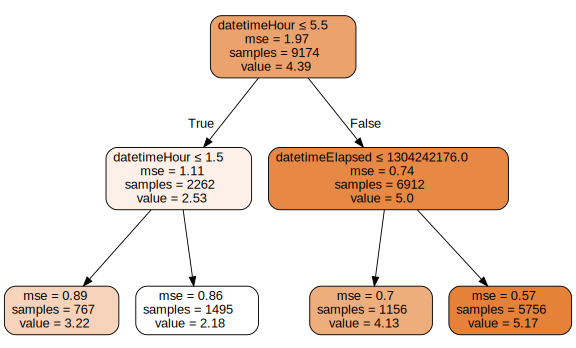

In [33]:
draw_tree(m_r, xs_r, size=8, leaves_parallel=True, precision=2)

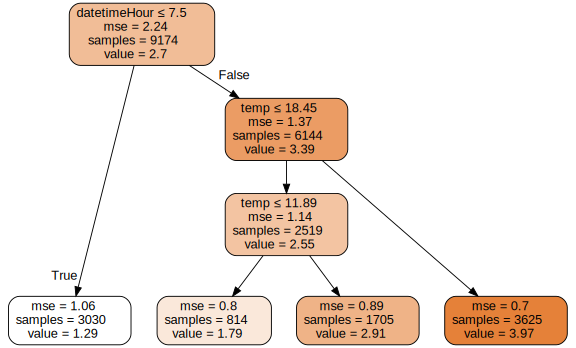

In [34]:
draw_tree(m_c, xs_c, size=8, leaves_parallel=True, precision=2)

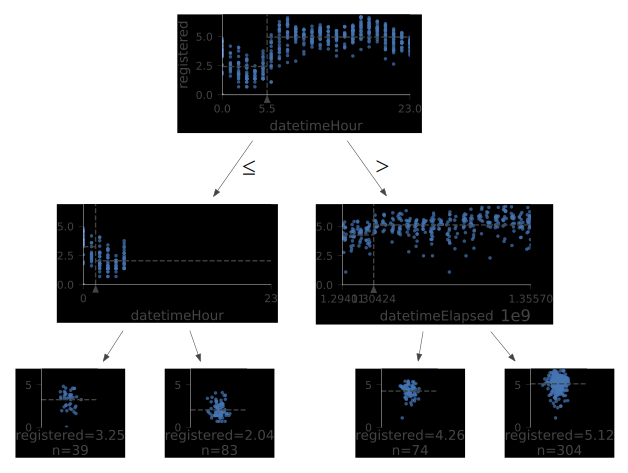

In [35]:
sampIdx = np.random.permutation(len(y_r))[:500]
dtreeviz(m_r, xs_r.iloc[sampIdx], y_r.iloc[sampIdx], xs_r.columns, depVar_r,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

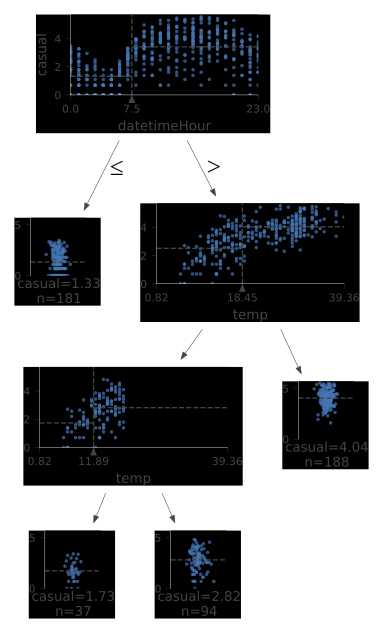

In [36]:
sampIdx = np.random.permutation(len(y_c))[:500]
dtreeviz(m_c, xs_c.iloc[sampIdx], y_c.iloc[sampIdx], xs_c.columns, depVar_c,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [37]:
m_r = DecisionTreeRegressor()
m_r.fit(xs_r, y_r)
m_c = DecisionTreeRegressor()
m_c.fit(xs_c, y_c)

DecisionTreeRegressor()

Now we'll create a function for the root mean squared error, `m_rmse`, because the competition was judged using the RMSLE (root mean squared log error) as the metric so since our counts are already the `log(counts)` using RMSE here is doing RMSLE.

In [38]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [39]:
print('registered: ', m_rmse(m_r, xs_r, y_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c))

registered:  0.0
casual:      0.0


Error is 0.0, i.e. model has perfectly fit training data because we gave it unlimited leaf nodes. Check valid to see if model is overfitting, which it obviously is,

In [40]:
print('registered: ', m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, validXs_c, validY_c))

registered:  0.468401
casual:      0.718384


So we are overfitting, because we have nearly as many leaf nodes as data points,

In [41]:
print('registered: ', m_r.get_n_leaves(), len(xs_r))
print('casual:     ', m_c.get_n_leaves(), len(xs_c))

registered:  8407 9174
casual:      7537 9174


Change stopping rule to have more data points in each leaf node,

In [42]:
m_r = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)
m_c = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)

m_r.fit(to_r.train.xs, to_r.train.y)
m_c.fit(to_c.train.xs, to_c.train.y)

print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.0 0.453546
casual:      0.0 0.741966


In [43]:
print('registered: ', m_r.get_n_leaves())
print('casual:     ', m_c.get_n_leaves())

registered:  8407
casual:      7536


### Creating a Random Forest

In [44]:
def rf(xs, y, n_estimators=1000, max_samples=None, max_features=0.5,
       min_samples_leaf=minLeafSamp, **kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True
                                ).fit(xs, y)

In [45]:
m_r = rf(xs_r, y_r)
m_c = rf(xs_c, y_c)

In [46]:
print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.106652 0.315021
casual:      0.169268 0.521441


Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [47]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
print('registered: ', r_mse(preds_r.mean(0), validY_r)) # mean is the same as whole forest above
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])
print('casual:     ', r_mse(preds_c.mean(0), validY_c)) # mean is the same as whole forest above

registered:  0.315021
casual:      0.521441


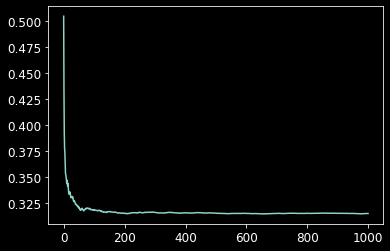

In [48]:
plt.plot([r_mse(preds_r[:i+1].mean(0), validY_r) for i in range(len(preds_r))]);

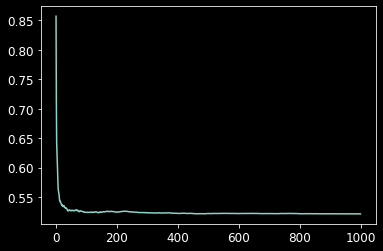

In [49]:
plt.plot([r_mse(preds_c[:i+1].mean(0), validY_c) for i in range(len(preds_c))]);

Out-of-Bag Error

In [50]:
print('train/valid registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('train/valid casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))
print('OOB         registered: ', r_mse(m_r.oob_prediction_, y_r))
print('OOB         casual:     ', r_mse(m_c.oob_prediction_, y_c))

train/valid registered:  0.106652 0.315021
train/valid casual:      0.169268 0.521441
OOB         registered:  0.289376
OOB         casual:      0.459272


OOB error being about equal to higher than validation error means that our model is generalizing slightly better to the validation set than it is to the rest of training set.

OOB error being lower than our validation error means that something else is causing that error, in addition to normal generalization error. 

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

In [51]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])

In [52]:
print('registered: ', preds_r.shape)
print('casual:     ', preds_c.shape)

registered:  (1000, 1712)
casual:      (1000, 1712)


In [53]:
predsSD_r = preds_r.std(0)
predsSD_c = preds_c.std(0)

In [54]:
print('registered: ', predsSD_r[:10])
print('casual:     ', predsSD_c[:10])

registered:  [0.69641952 0.89199831 0.88462124 0.73498189 0.64586297 0.62569798 1.18831926 1.17227422 1.01210105 0.7340063 ]
casual:      [0.67334966 0.66122296 0.71484344 0.65743139 0.56594033 0.54728633 0.5563293  0.67778444 0.79595122 0.78900843]


Some predictions are more confident than others based on whether most trees agree or not. This can be seen by varying magnitudes of standard deviation.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [55]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [56]:
fi_r = rf_feat_importance(m_r, xs_r)
fi_r[:10]

,cols,imp
22,datetimeHour,0.700179
23,datetimeElapsed,0.069578
17,humidity,0.040735
6,datetimeDayofweek,0.033570
16,atemp,0.032246
2,workingday,0.029677
15,temp,0.027657
21,datetimeDayofyear,0.017805
4,datetimeYear,0.009175
3,weather,0.008855


In [57]:
fi_c = rf_feat_importance(m_c, xs_c)
fi_c[:10]

,cols,imp
22,datetimeHour,0.490458
16,atemp,0.131158
15,temp,0.111844
17,humidity,0.053103
21,datetimeDayofyear,0.038904
23,datetimeElapsed,0.037102
2,workingday,0.032614
6,datetimeDayofweek,0.027406
19,datetimeWeek,0.020726
3,weather,0.014316


In [58]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

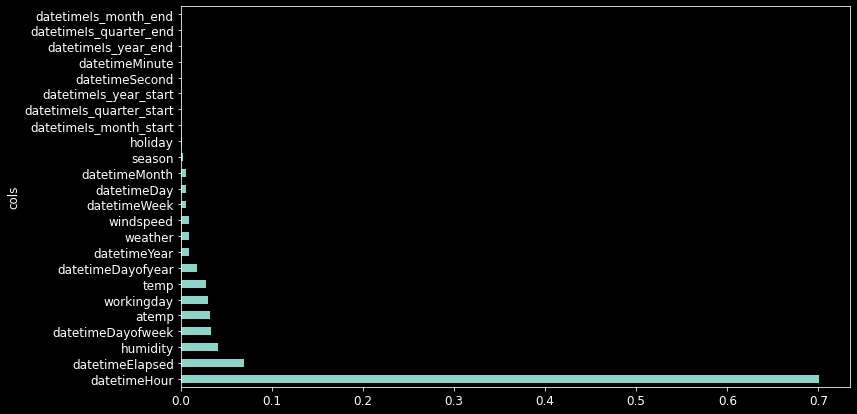

In [59]:
plot_fi(fi_r[:]);

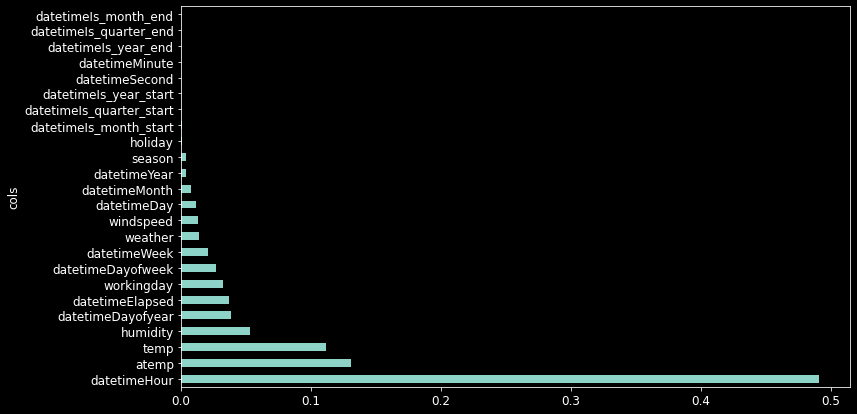

In [60]:
plot_fi(fi_c[:]);

For both `registered` and `casual` rentals `datetimeHour` was by far the most important factor which makes sense. `registered` rentals are completely dominated by the `datetimeHour` whereas `casual` rentals have a bit more spread out importance with `temp` and `atemp`.

I think it's promising to see that these two types of rentals indeed have different feature importances. I think this means that separating their predictions will be beneficial.

### Remove Low-Importance Variables

The following columns will be dropped:

In [61]:
print('registered: \n', fi_r[fi_r.imp<=0.0005].cols, sep='')
print('\n')
print('casual:     \n', fi_c[fi_c.imp<=0.0005].cols, sep='')

registered: 
8       datetimeIs_month_start
10    datetimeIs_quarter_start
12       datetimeIs_year_start
14              datetimeSecond
13              datetimeMinute
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


casual:     
10    datetimeIs_quarter_start
12       datetimeIs_year_start
14              datetimeSecond
13              datetimeMinute
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


The following columns will be kept:

In [62]:
toKeep_r = fi_r[fi_r.imp>0.0005].cols
toKeep_c = fi_c[fi_c.imp>0.0005].cols
print('registered: \n', toKeep_r, sep='')
print('\n')
print('casual:     \n', toKeep_c, sep='')

registered: 
22         datetimeHour
23      datetimeElapsed
17             humidity
6     datetimeDayofweek
16                atemp
2            workingday
15                 temp
21    datetimeDayofyear
4          datetimeYear
3               weather
18            windspeed
19         datetimeWeek
20          datetimeDay
5         datetimeMonth
0                season
1               holiday
Name: cols, dtype: object


casual:     
22              datetimeHour
16                     atemp
15                      temp
17                  humidity
21         datetimeDayofyear
23           datetimeElapsed
2                 workingday
6          datetimeDayofweek
19              datetimeWeek
3                    weather
18                 windspeed
20               datetimeDay
5              datetimeMonth
4               datetimeYear
0                     season
1                    holiday
8     datetimeIs_month_start
Name: cols, dtype: object


I think I need to make two different test sets here because the important variables are different and I need to drop different columns for the two different predictions,

In [63]:
xsImp_r = xs_r[toKeep_r]
xsImp_c = xs_c[toKeep_c]

validXsImp_r = validXs_r[toKeep_r]
validXsImp_c = validXs_c[toKeep_c]

testXsImp_r = testXs[toKeep_r]
testXsImp_c = testXs[toKeep_c]

In [64]:
print(xsImp_r.columns == validXsImp_r.columns)
print(xsImp_r.columns == testXsImp_r.columns)

print(xsImp_c.columns == validXsImp_c.columns)
print(xsImp_c.columns == testXsImp_c.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


All columns for training, validation, and testing are the same for `registered` and `casual` respectively.

In [65]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

In [66]:
print('Error after importance filtering:')
print('registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

Error after importance filtering:
registered:  0.106002 0.313559
casual:      0.169203 0.524077


Our accuracy is about the same, even a bit better, and now our model is simpler to train.

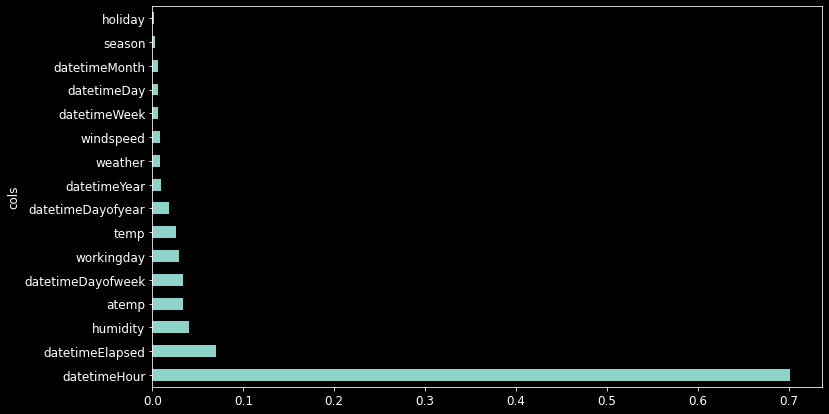

In [67]:
plot_fi(rf_feat_importance(m_r, xsImp_r));

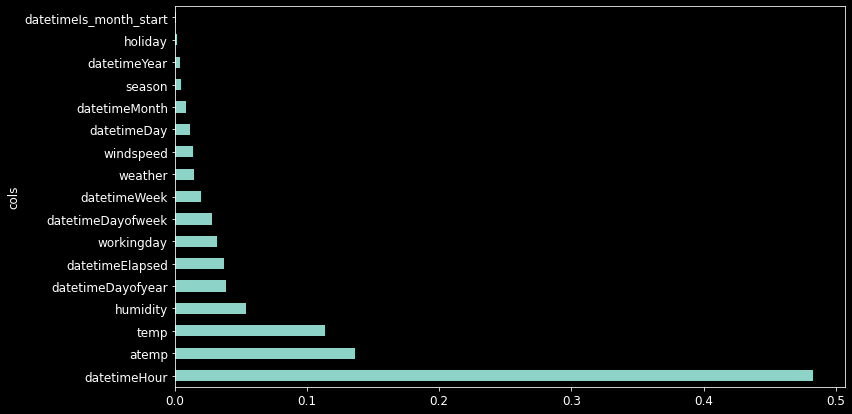

In [68]:
plot_fi(rf_feat_importance(m_c, xsImp_c));

### Remove Redundant Features

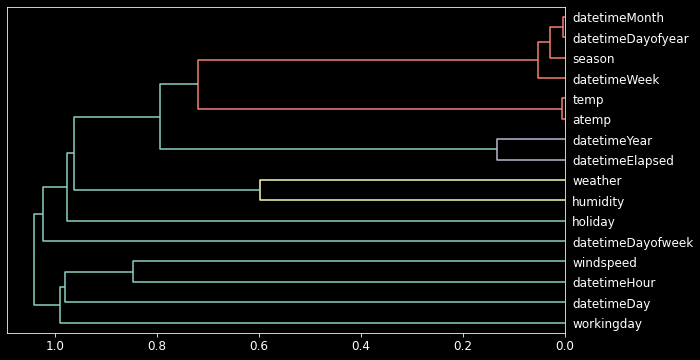

In [69]:
cluster_columns(xsImp_r)

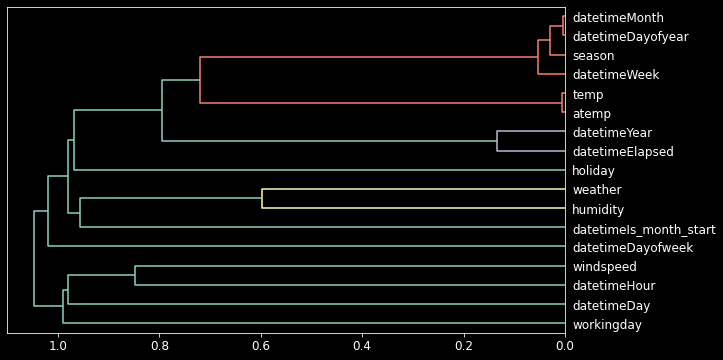

In [70]:
cluster_columns(xsImp_c)

We could try removing `datetimeMonth / datetimeDayofyear` and `temp / atemp`,

In [71]:
def get_oob(df, y):
    #m = RandomForestRegressor(n_estimators=80, min_samples_leaf=15, max_samples=None,
    #                          max_features=0.5, n_jobs=-1, oob_score=True)
    #m.fit(df, y)
    m = rf(df, y, max_samples=None)
    
    return m.oob_score_

In [72]:
print('Baseline OOB scores')
print('registered: ', get_oob(xsImp_r, y_r))
print('casual:     ', get_oob(xsImp_c, y_c))

Baseline OOB scores
registered:  0.957359482919137
casual:      0.9058739167438921


In [73]:
print('registered:')
{c:get_oob(xsImp_r.drop(c, axis=1), y_r) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

registered:


{'temp': 0.9568522450573241,
 'atemp': 0.9571072821635478,
 'datetimeMonth': 0.9563473912305077,
 'datetimeDayofyear': 0.956350200435949}

The OOB score is potentially slightly higher when dropping `atemp` or `datetimeDayofyear` but those changes are so small that rerunning sometimes makes them lower.

In [74]:
toDrop_r = []

In [75]:
print('casual:')
{c:get_oob(xsImp_c.drop(c, axis=1), y_c) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

casual:


{'temp': 0.9055877348187865,
 'atemp': 0.9064786742181927,
 'datetimeMonth': 0.9057724261405422,
 'datetimeDayofyear': 0.9053273198039503}

The OOB score for dropping `atemp` from `casual` is consistently about three thousandths higher than the original OOB score.

In [76]:
toDrop_c = ['atemp']

In [77]:
print('registered: \n', xsImp_r.columns, sep='')
print('\n')
print('casual:     \n', xsImp_c.columns, sep='')

registered: 
Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
       'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
       'weather', 'windspeed', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
       'season', 'holiday'],
      dtype='object')


casual:     
Index(['datetimeHour', 'atemp', 'temp', 'humidity', 'datetimeDayofyear',
       'datetimeElapsed', 'workingday', 'datetimeDayofweek', 'datetimeWeek',
       'weather', 'windspeed', 'datetimeDay', 'datetimeMonth', 'datetimeYear',
       'season', 'holiday', 'datetimeIs_month_start'],
      dtype='object')


In [78]:
print('registered: ', get_oob(xsImp_r.drop(toDrop_r, axis=1), y_r))
print('casual:     ', get_oob(xsImp_c.drop(toDrop_c, axis=1), y_c))

registered:  0.9573980553955695
casual:      0.9067623928477045


Dropping `datetimeMonth` gives a little higher OOB score for `registered` and dropping nothing keeps `casual` the same.

In [79]:
xsFinal_r = xsImp_r.drop(toDrop_r, axis=1)
xsFinal_c = xsImp_c.drop(toDrop_c, axis=1)

validXsFinal_r = validXsImp_r.drop(toDrop_r, axis=1)
validXsFinal_c = validXsImp_c.drop(toDrop_c, axis=1)

testXsFinal_r = testXsImp_r.drop(toDrop_r, axis=1)
testXsFinal_c = testXsImp_c.drop(toDrop_c, axis=1)

xsFinal_r.columns, validXsFinal_r.columns

(Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
        'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
        'weather', 'windspeed', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
        'season', 'holiday'],
       dtype='object'),
 Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
        'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
        'weather', 'windspeed', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
        'season', 'holiday'],
       dtype='object'))

In [80]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

print('Before registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('Before casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('After registered:  ', m_rmse(m_r, xsFinal_r, y_r), m_rmse(m_r, validXsFinal_r, validY_r))
print('After casual:      ', m_rmse(m_c, xsFinal_c, y_c), m_rmse(m_c, validXsFinal_c, validY_c))

Before registered:  0.106441 0.313614
Before casual:      0.1691 0.523367
After registered:   0.106265 0.312998
After casual:       0.16817 0.517926


Valid error is a little less for `registered` than it was before redundant feature removal which makes sense because we didn't remove anything from the `casual` dataset.

### Partial Dependence

In [81]:
to_c.classes['season']

['#na#', 1, 2, 3, 4]

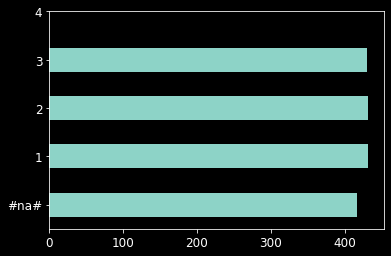

In [82]:
# all remaining variables are continuous so a bar plot doesn't really apply.
p = validXs_r['season'].value_counts(sort=False).plot.barh()
c = to_r.classes['season']
plt.yticks(ticks=range(len(c)), labels=c);

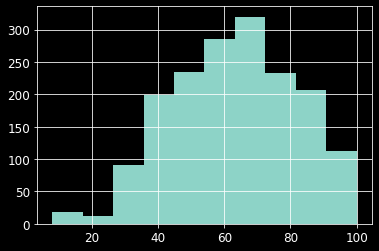

In [83]:
ax = validXsFinal_r['humidity'].hist()

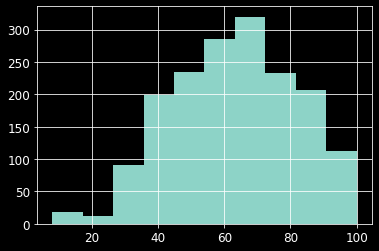

In [84]:
ax = validXsFinal_c['humidity'].hist()

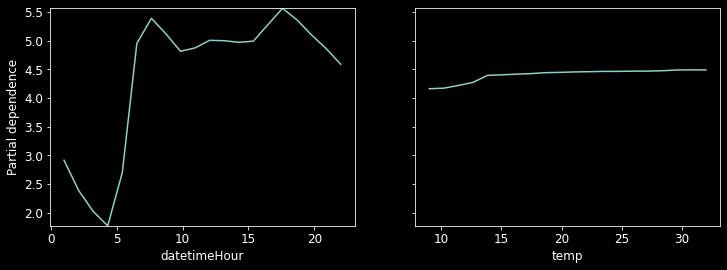

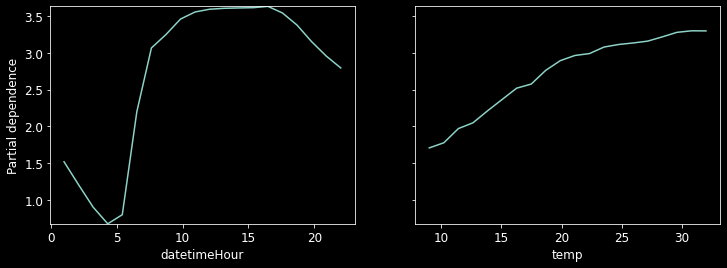

In [85]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_r, validXsFinal_r,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_c, validXsFinal_c,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

The ordinate (counts) is log-scale so a linear dependence is actually an exponential dependence.

### Tree Interpreter

In [86]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [87]:
row_r = validXsFinal_r.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_r, row_r.values)

In [88]:
prediction[0], bias[0], contributions[0].sum()

(array([2.64022125]), 4.386982755708932, -1.7467615063669681)

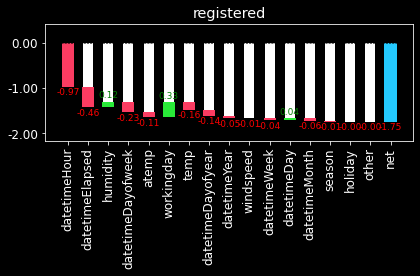

In [89]:
waterfall(validXsFinal_r.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='registered');

In [90]:
row_c = validXsFinal_c.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_c, row_c.values)

In [91]:
prediction[0], bias[0], contributions[0].sum()

(array([0.95865181]), 2.6954217678020536, -1.7367699579904616)

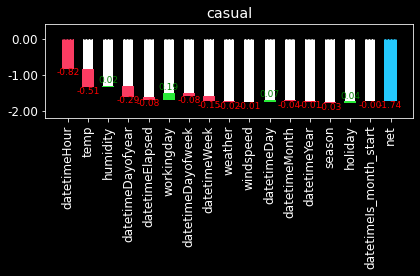

In [92]:
waterfall(validXsFinal_c.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='casual');

This information answers the question: "for predicting a particular row of data, what were the most important factors and how did they influence the prediction?"

For some of these categories the signs are flipped between `registered` and `casual`. I'm not entirely sure what that means but I'd guess that these categores have an inverse impact on count between the two types of counts which is interesting.

## Extrapolation and Neural Networks

### Finding Out-of-Domain Data

Concatenate training and validation data and label them with 0 for training and 1 for valid, then calculate importance of each column for predicting valid or not.

In [93]:
dfDom_r = pd.concat([xsFinal_r, validXsFinal_r])
isValid_r = np.array([0]*len(xsFinal_r) + [1]*len(validXsFinal_r))

dfDom_c = pd.concat([xsFinal_c, validXsFinal_c])
isValid_c = np.array([0]*len(xsFinal_c) + [1]*len(validXsFinal_c))

In [94]:
m_r = rf(dfDom_r, isValid_r)
rf_feat_importance(m_r, dfDom_r)

,cols,imp
12,datetimeDay,9.642067e-01
7,datetimeDayofyear,2.088936e-02
1,datetimeElapsed,6.301649e-03
11,datetimeWeek,4.354250e-03
13,datetimeMonth,1.883515e-03
6,temp,6.918741e-04
3,datetimeDayofweek,5.264209e-04
4,atemp,3.418626e-04
5,workingday,2.901128e-04
8,datetimeYear,2.153999e-04


In [95]:
m_c = rf(dfDom_c, isValid_c)
rf_feat_importance(m_c, dfDom_c)

,cols,imp
10,datetimeDay,9.624074e-01
3,datetimeDayofyear,2.158034e-02
4,datetimeElapsed,6.188547e-03
7,datetimeWeek,4.638052e-03
11,datetimeMonth,2.271469e-03
1,temp,6.941142e-04
6,datetimeDayofweek,5.959572e-04
13,season,4.447258e-04
15,datetimeIs_month_start,4.309981e-04
5,workingday,3.474158e-04


These are the scores of how important each column is in determining if a given row is in the validation set or the training set.

`datetimeDay` makes sense because the validation set days are at the end of the month, i.e. 16-20 based on how I set it earlier. 

`datetimeDayofyear` makes some sense for the same reason though since it ranges from 1-354 it doesn't have the same level of predictive power for valid vs. training because the numbers don't repeat as explicitly as `datetimeDay` does.

In [96]:
print('registered:')
tuple(dfDom_r.columns)

registered:


('datetimeHour',
 'datetimeElapsed',
 'humidity',
 'datetimeDayofweek',
 'atemp',
 'workingday',
 'temp',
 'datetimeDayofyear',
 'datetimeYear',
 'weather',
 'windspeed',
 'datetimeWeek',
 'datetimeDay',
 'datetimeMonth',
 'season',
 'holiday')

In [97]:
print('casual:')
tuple(dfDom_c.columns)

casual:


('datetimeHour',
 'temp',
 'humidity',
 'datetimeDayofyear',
 'datetimeElapsed',
 'workingday',
 'datetimeDayofweek',
 'datetimeWeek',
 'weather',
 'windspeed',
 'datetimeDay',
 'datetimeMonth',
 'datetimeYear',
 'season',
 'holiday',
 'datetimeIs_month_start')

In [98]:
m_r = rf(xsFinal_r, y_r)
print('registered orig:', m_rmse(m_r, validXsFinal_r, validY_r))

categories = tuple(dfDom_r.columns)

for c in categories:
    m_r = rf(xsFinal_r.drop(c, axis=1), y_r)
    print(c, m_rmse(m_r, validXsFinal_r.drop(c, axis=1), validY_r))

registered orig: 0.31445
datetimeHour 1.224714
datetimeElapsed 0.321532
humidity 0.338163
datetimeDayofweek 0.349239
atemp 0.32187
workingday 0.341503
temp 0.321911
datetimeDayofyear 0.319682
datetimeYear 0.32002
weather 0.334147
windspeed 0.321935
datetimeWeek 0.319928
datetimeDay 0.32125
datetimeMonth 0.320981
season 0.320527
holiday 0.322875


The error is not lowered from the original value of 0.321061 by dropping any of the columns.

In [99]:
# toDrop_r = []

# xsFinal_r = xsFinal_r.drop(columns=toDrop_r)
# validXsFinal_r = validXsFinal_r.drop(columns=toDrop_r)
# testXsFinal_r = testXsFinal_r.drop(columns=toDrop_r)

In [100]:
m_c = rf(xsFinal_c, y_c)
print('casual orig:', m_rmse(m_c, validXsFinal_c, validY_c))

categories = tuple(dfDom_c.columns)

for c in categories:
    m_c = rf(xsFinal_c.drop(c, axis=1), y_c)
    print(c, m_rmse(m_c, validXsFinal_c.drop(c, axis=1), validY_c))

casual orig: 0.517698
datetimeHour 1.089194
temp 0.628038
humidity 0.561033
datetimeDayofyear 0.521335
datetimeElapsed 0.523881
workingday 0.522975
datetimeDayofweek 0.54735
datetimeWeek 0.522605
weather 0.531075
windspeed 0.522347
datetimeDay 0.507255
datetimeMonth 0.518956
datetimeYear 0.521352
season 0.518939
holiday 0.522155
datetimeIs_month_start 0.520067


From the original RMSLE of 0.514575 it get's lower aka better if we drop `datetimeDay` for the `casual` count predictions.

In [101]:
toDrop = ['datetimeDay']

xsFinal_c = xsFinal_c.drop(columns=toDrop)
validXsFinal_c = validXsFinal_c.drop(columns=toDrop)
testXsFinal_c = testXsFinal_c.drop(columns=toDrop)

Remake the model now that we've dropped columns,

In [102]:
m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.314271
casual final: 0.508687


Now predict the test set with only the random forest,

In [103]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest_r, rfPredsTest_c

(array([2.34844852, 1.83403469, 1.24849554, ..., 5.12073695, 4.73116931, 4.34954633]),
 array([0.87886208, 0.55986212, 0.5561402 , ..., 1.82912234, 1.6701914 , 1.35920821]))

## Using a Neural Network

In [104]:
dfNN = pd.read_csv(path/'train.csv', low_memory=False)

dfNN[depVar]   = np.log(dfNN[depVar]   + 1)
dfNN[depVar_r] = np.log(dfNN[depVar_r] + 1)
dfNN[depVar_c] = np.log(dfNN[depVar_c] + 1)

dfNN = add_datepart(dfNN, 'datetime', time=True)

In [105]:
dfNNTest = pd.read_csv(path/'test.csv', low_memory=False)
dfNNTest = add_datepart(dfNNTest, 'datetime', time=True)

In [106]:
' '.join(o for o in dfNN.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

We can use the work we did with the RF to trim unwanted columns for the NN. Here are the columns we kept for the RF,

In [107]:
print('registered:', xsFinal_r.columns, len(xsFinal_r.columns))
print('casual:    ', xsFinal_c.columns, len(xsFinal_c.columns))

registered: Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
       'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
       'weather', 'windspeed', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
       'season', 'holiday'],
      dtype='object') 16
casual:     Index(['datetimeHour', 'temp', 'humidity', 'datetimeDayofyear',
       'datetimeElapsed', 'workingday', 'datetimeDayofweek', 'datetimeWeek',
       'weather', 'windspeed', 'datetimeMonth', 'datetimeYear', 'season',
       'holiday', 'datetimeIs_month_start'],
      dtype='object') 15


In [108]:
combined = pd.concat([dfNN, dfNNTest])
dfNNFinal_r = combined[list(xsFinal_r.columns) + [depVar_r]]
dfNNFinal_r

,datetimeHour,datetimeElapsed,humidity,datetimeDayofweek,atemp,workingday,temp,datetimeDayofyear,datetimeYear,weather,windspeed,datetimeWeek,datetimeDay,datetimeMonth,season,holiday,registered
0,0,1.293840e+09,81,5,14.395,0,9.84,1,2011,1,0.0000,52,1,1,1,0,2.639057
1,1,1.293844e+09,80,5,13.635,0,9.02,1,2011,1,0.0000,52,1,1,1,0,3.496508
2,2,1.293847e+09,80,5,13.635,0,9.02,1,2011,1,0.0000,52,1,1,1,0,3.332205
3,3,1.293851e+09,75,5,14.395,0,9.84,1,2011,1,0.0000,52,1,1,1,0,2.397895
4,4,1.293854e+09,75,5,14.395,0,9.84,1,2011,1,0.0000,52,1,1,1,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,1.356980e+09,60,0,12.880,1,10.66,366,2012,2,11.0014,1,31,12,1,0,NaN
6489,20,1.356984e+09,60,0,12.880,1,10.66,366,2012,2,11.0014,1,31,12,1,0,NaN
6490,21,1.356988e+09,60,0,12.880,1,10.66,366,2012,1,11.0014,1,31,12,1,0,NaN
6491,22,1.356991e+09,56,0,13.635,1,10.66,366,2012,1,8.9981,1,31,12,1,0,NaN


In [109]:
#dfNNFinal_r = dfNN[list(xsFinal_r.columns) + [depVar_r]]
#dfNNFinal_r

In [110]:
dfNNFinal_c = combined[list(xsFinal_c.columns) + [depVar_c]]
dfNNFinal_c

,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,workingday,datetimeDayofweek,datetimeWeek,weather,windspeed,datetimeMonth,datetimeYear,season,holiday,datetimeIs_month_start,casual
0,0,9.84,81,1,1.293840e+09,0,5,52,1,0.0000,1,2011,1,0,True,1.386294
1,1,9.02,80,1,1.293844e+09,0,5,52,1,0.0000,1,2011,1,0,True,2.197225
2,2,9.02,80,1,1.293847e+09,0,5,52,1,0.0000,1,2011,1,0,True,1.791759
3,3,9.84,75,1,1.293851e+09,0,5,52,1,0.0000,1,2011,1,0,True,1.386294
4,4,9.84,75,1,1.293854e+09,0,5,52,1,0.0000,1,2011,1,0,True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,10.66,60,366,1.356980e+09,1,0,1,2,11.0014,12,2012,1,0,False,NaN
6489,20,10.66,60,366,1.356984e+09,1,0,1,2,11.0014,12,2012,1,0,False,NaN
6490,21,10.66,60,366,1.356988e+09,1,0,1,1,11.0014,12,2012,1,0,False,NaN
6491,22,10.66,56,366,1.356991e+09,1,0,1,1,8.9981,12,2012,1,0,False,NaN


In [111]:
#dfNNFinal_c = dfNN[list(xsFinal_c.columns) + [depVar_c]]
#dfNNFinal_c

In [112]:
#dfNNFinalTest_r = dfNNTest[list(xsFinal_r.columns)]
#dfNNFinalTest_r

In [113]:
#dfNNFinalTest_c = dfNNTest[list(xsFinal_c.columns)]
#dfNNFinalTest_c

##### `registered`

In [114]:
contNN_r,catNN_r = cont_cat_split(dfNNFinal_r, max_card=18, dep_var=depVar_r)

In [115]:
dfNNFinal_r[catNN_r].nunique()

datetimeDayofweek     7
workingday            2
datetimeYear          2
weather               4
datetimeMonth        12
season                4
holiday               2
dtype: int64

In [116]:
dfNNFinal_r[contNN_r].nunique()

datetimeHour            24
datetimeElapsed      17379
humidity                89
atemp                   65
temp                    50
datetimeDayofyear      366
windspeed               30
datetimeWeek            52
datetimeDay             31
dtype: int64

It seems to me that some of these variables although somewhat lower in cardinality are continuous in nature.

Specifically, `datetimeDayofyear` and `datetimeWeek` are categorical in nature, though since the predicting on the test set gives errors for out of domain categorical variables let's keep `datetimeDayofyear`, `datetimeWeek`, and `datetimeDay` as `cont` variables.

In [117]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_r.remove(i)
    catNN_r.append(i)
    
print('catNN:', catNN_r)
print('contNN:', contNN_r)

catNN: ['datetimeDayofweek', 'workingday', 'datetimeYear', 'weather', 'datetimeMonth', 'season', 'holiday', 'datetimeHour']
contNN: ['datetimeElapsed', 'humidity', 'atemp', 'temp', 'datetimeDayofyear', 'windspeed', 'datetimeWeek', 'datetimeDay']


##### `casual`

In [118]:
contNN_c,catNN_c = cont_cat_split(dfNNFinal_c, max_card=18, dep_var=depVar_c)

In [119]:
dfNNFinal_c[catNN_c].nunique()

workingday                 2
datetimeDayofweek          7
weather                    4
datetimeMonth             12
datetimeYear               2
season                     4
holiday                    2
datetimeIs_month_start     2
dtype: int64

In [120]:
dfNNFinal_c[contNN_c].nunique()

datetimeHour            24
temp                    50
humidity                89
datetimeDayofyear      366
datetimeElapsed      17379
datetimeWeek            52
windspeed               30
dtype: int64

In [121]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_c.remove(i)
    catNN_c.append(i)
    
print('catNN:', catNN_c)
print('contNN:', contNN_c)

catNN: ['workingday', 'datetimeDayofweek', 'weather', 'datetimeMonth', 'datetimeYear', 'season', 'holiday', 'datetimeIs_month_start', 'datetimeHour']
contNN: ['temp', 'humidity', 'datetimeDayofyear', 'datetimeElapsed', 'datetimeWeek', 'windspeed']


Testing dataframes don't need to be checked because we altered the lists of columns themselves.

Create `TabularPandas` object in the same was as before but with `Normalize` since we're using it for an NN.

In [122]:
procsNN = [Categorify, FillMissing, Normalize]
toNN_r = TabularPandas(dfNNFinal_r,
                       procs=procs,
                       cat_names=catNN_r,
                       cont_names=contNN_r,
                       y_names=depVar_r,
                       splits=splits)

toNN_c = TabularPandas(dfNNFinal_c,
                       procs=procs,
                       cat_names=catNN_c,
                       cont_names=contNN_c,
                       y_names=depVar_c,
                       splits=splits)

#toNNtest_r = TabularPandas(dfNNFinalTest_r,
#                           procs=procs,
#                           cat_names=catNN_r,
#                           cont_names=contNN_r,
#                           splits=None)

#toNNtest_c = TabularPandas(dfNNFinalTest_c,
#                           procs=procs,
#                           cat_names=catNN_c,
#                           cont_names=contNN_c,
#                           splits=None)

In [123]:
toNN_r.show()

,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,5,0,2011,1,1,1,0,0,1.293840e+09,81,14.395000,9.84,1,0.0000,52,1,2.639057
1,5,0,2011,1,1,1,0,1,1.293844e+09,80,13.635000,9.02,1,0.0000,52,1,3.496508
2,5,0,2011,1,1,1,0,2,1.293847e+09,80,13.635000,9.02,1,0.0000,52,1,3.332205
3,5,0,2011,1,1,1,0,3,1.293851e+09,75,14.395000,9.84,1,0.0000,52,1,2.397895
4,5,0,2011,1,1,1,0,4,1.293854e+09,75,14.395000,9.84,1,0.0000,52,1,0.693147
5,5,0,2011,2,1,1,0,5,1.293858e+09,75,12.880000,9.84,1,6.0032,52,1,0.693147
6,5,0,2011,1,1,1,0,6,1.293862e+09,80,13.635000,9.02,1,0.0000,52,1,0.000000
7,5,0,2011,1,1,1,0,7,1.293865e+09,86,12.880000,8.20,1,0.0000,52,1,1.098612
8,5,0,2011,1,1,1,0,8,1.293869e+09,75,14.395000,9.84,1,0.0000,52,1,2.079442
9,5,0,2011,1,1,1,0,9,1.293872e+09,76,17.424999,13.12,1,0.0000,52,1,1.945910


Tabular models don't generally need much GPU ram so we can have bigger batch sizes,

I think creating the `TabularPandas` objects with dataframes that have both training and test data will initialize the NN such that the range of categories that are unique to the test set will not cause errors down the line.

In [124]:
toTrainNN_r = TabularPandas(dfNNFinal_r[:len(dfNN)],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                            splits=splits
                           )
toTrainNN_r.show()

toTestNN_r = TabularPandas(dfNNFinal_r[len(dfNN):],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                           )
toTestNN_r.show()

,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,5,0,2011,1,1,1,0,0,1.293840e+09,81,14.395000,9.84,1,0.0000,52,1,2.639057
1,5,0,2011,1,1,1,0,1,1.293844e+09,80,13.635000,9.02,1,0.0000,52,1,3.496508
2,5,0,2011,1,1,1,0,2,1.293847e+09,80,13.635000,9.02,1,0.0000,52,1,3.332205
3,5,0,2011,1,1,1,0,3,1.293851e+09,75,14.395000,9.84,1,0.0000,52,1,2.397895
4,5,0,2011,1,1,1,0,4,1.293854e+09,75,14.395000,9.84,1,0.0000,52,1,0.693147
5,5,0,2011,2,1,1,0,5,1.293858e+09,75,12.880000,9.84,1,6.0032,52,1,0.693147
6,5,0,2011,1,1,1,0,6,1.293862e+09,80,13.635000,9.02,1,0.0000,52,1,0.000000
7,5,0,2011,1,1,1,0,7,1.293865e+09,86,12.880000,8.20,1,0.0000,52,1,1.098612
8,5,0,2011,1,1,1,0,8,1.293869e+09,75,14.395000,9.84,1,0.0000,52,1,2.079442
9,5,0,2011,1,1,1,0,9,1.293872e+09,76,17.424999,13.12,1,0.0000,52,1,1.945910


,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,3,1,2011,1,1,1,0,0,1.295482e+09,56,11.365,10.66,20,26.002701,3,20,NaN
1,3,1,2011,1,1,1,0,1,1.295485e+09,56,13.635,10.66,20,0.000000,3,20,NaN
2,3,1,2011,1,1,1,0,2,1.295489e+09,56,13.635,10.66,20,0.000000,3,20,NaN
3,3,1,2011,1,1,1,0,3,1.295492e+09,56,12.880,10.66,20,11.001400,3,20,NaN
4,3,1,2011,1,1,1,0,4,1.295496e+09,56,12.880,10.66,20,11.001400,3,20,NaN
5,3,1,2011,1,1,1,0,5,1.295500e+09,60,11.365,9.84,20,15.001300,3,20,NaN
6,3,1,2011,1,1,1,0,6,1.295503e+09,60,10.605,9.02,20,15.001300,3,20,NaN
7,3,1,2011,1,1,1,0,7,1.295507e+09,55,10.605,9.02,20,15.001300,3,20,NaN
8,3,1,2011,1,1,1,0,8,1.295510e+09,55,10.605,9.02,20,19.001200,3,20,NaN
9,3,1,2011,2,1,1,0,9,1.295514e+09,52,11.365,9.84,20,15.001300,3,20,NaN


In [125]:
toTrainNN_c = TabularPandas(dfNNFinal_c[:len(dfNN)],
                            procs=procs,
                            cat_names=catNN_c,
                            cont_names=contNN_c,
                            y_names=depVar_c,
                            splits=splits
                           )
toTrainNN_c.show()

toTestNN_c = TabularPandas(dfNNFinal_c[len(dfNN):],
                           procs=procs,
                           cat_names=catNN_c,
                           cont_names=contNN_c,
                           y_names=depVar_c,
                          )
toTestNN_c.show()

,workingday,datetimeDayofweek,weather,datetimeMonth,datetimeYear,season,holiday,datetimeIs_month_start,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,windspeed,casual
0,0,5,1,1,2011,1,0,True,0,9.84,81,1,1.293840e+09,52,0.0000,1.386294
1,0,5,1,1,2011,1,0,True,1,9.02,80,1,1.293844e+09,52,0.0000,2.197225
2,0,5,1,1,2011,1,0,True,2,9.02,80,1,1.293847e+09,52,0.0000,1.791759
3,0,5,1,1,2011,1,0,True,3,9.84,75,1,1.293851e+09,52,0.0000,1.386294
4,0,5,1,1,2011,1,0,True,4,9.84,75,1,1.293854e+09,52,0.0000,0.000000
5,0,5,2,1,2011,1,0,True,5,9.84,75,1,1.293858e+09,52,6.0032,0.000000
6,0,5,1,1,2011,1,0,True,6,9.02,80,1,1.293862e+09,52,0.0000,1.098612
7,0,5,1,1,2011,1,0,True,7,8.20,86,1,1.293865e+09,52,0.0000,0.693147
8,0,5,1,1,2011,1,0,True,8,9.84,75,1,1.293869e+09,52,0.0000,0.693147
9,0,5,1,1,2011,1,0,True,9,13.12,76,1,1.293872e+09,52,0.0000,2.197225


,workingday,datetimeDayofweek,weather,datetimeMonth,datetimeYear,season,holiday,datetimeIs_month_start,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,windspeed,casual
0,1,3,1,1,2011,1,0,False,0,10.66,56,20,1.295482e+09,3,26.002701,NaN
1,1,3,1,1,2011,1,0,False,1,10.66,56,20,1.295485e+09,3,0.000000,NaN
2,1,3,1,1,2011,1,0,False,2,10.66,56,20,1.295489e+09,3,0.000000,NaN
3,1,3,1,1,2011,1,0,False,3,10.66,56,20,1.295492e+09,3,11.001400,NaN
4,1,3,1,1,2011,1,0,False,4,10.66,56,20,1.295496e+09,3,11.001400,NaN
5,1,3,1,1,2011,1,0,False,5,9.84,60,20,1.295500e+09,3,15.001300,NaN
6,1,3,1,1,2011,1,0,False,6,9.02,60,20,1.295503e+09,3,15.001300,NaN
7,1,3,1,1,2011,1,0,False,7,9.02,55,20,1.295507e+09,3,15.001300,NaN
8,1,3,1,1,2011,1,0,False,8,9.02,55,20,1.295510e+09,3,19.001200,NaN
9,1,3,2,1,2011,1,0,False,9,9.84,52,20,1.295514e+09,3,15.001300,NaN


In [126]:
print('Y-ranges for each set:')
y_r = toNN_r.train.y
print('registered:', y_r.min(), y_r.max())
y_c = toNN_c.train.y
print('casual:', y_c.min(), y_c.max())

Y-ranges for each set:
registered: 0.0 6.787845
casual: 0.0 5.894403


In [127]:
dls_r = toTrainNN_r.dataloaders(bs=1024)
dls_c = toTrainNN_c.dataloaders(bs=1024)

learn_r = tabular_learner(dls_r, layers=[layer1,layer2,layer3], n_out=1,
                         y_range=(0,7), loss_func=F.mse_loss)
learn_c = tabular_learner(dls_c, layers=[layer1,layer2,layer3], n_out=1,
                         y_range=(0,6), loss_func=F.mse_loss)

registered:
lrMin/10: 0.017378008365631102 lrSteep: 0.0010000000474974513


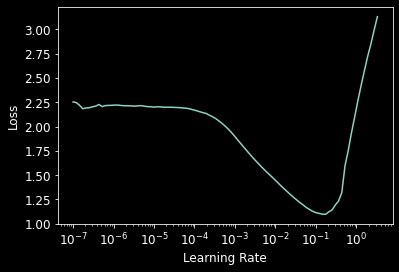

In [128]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.014454397559165954 lrSteep: 0.0014454397605732083


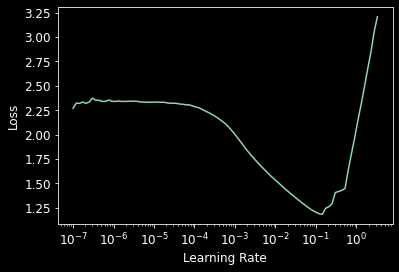

In [129]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

epoch,train_loss,valid_loss,time
0,1.150001,2.066905,00:00
1,0.675012,3.463597,00:00
2,0.464811,2.603842,00:00
3,0.356921,1.579534,00:00
4,0.286409,1.303370,00:00
5,0.237860,0.704403,00:00
6,0.203872,0.300532,00:00
7,0.176460,0.186306,00:00
8,0.155954,0.103088,00:00
9,0.139225,0.082587,00:00


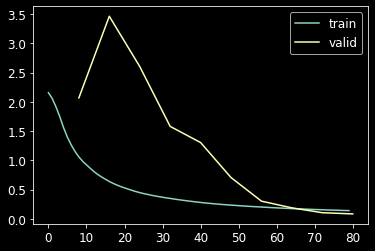

In [130]:
learn_r.fit_one_cycle(trainEpochs1_r, lr_max=lrMin_r)
learn_r.recorder.plot_loss(skip_start=0)

epoch,train_loss,valid_loss,time
0,1.387731,2.002336,00:00
1,0.883759,2.684025,00:00
2,0.668827,3.374368,00:00
3,0.540060,1.976138,00:00
4,0.456763,1.470404,00:00
5,0.401157,0.812452,00:00
6,0.358666,0.530950,00:00
7,0.325472,0.340022,00:00
8,0.300473,0.320362,00:00
9,0.279580,0.274234,00:00


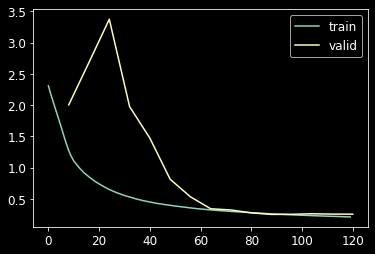

In [131]:
learn_c.fit_one_cycle(trainEpochs1_c, lr_max=lrMin_c)
learn_c.recorder.plot_loss(skip_start=0)

registered:
lrMin/10: 4.78630090583465e-07 lrSteep: 4.365158383734524e-05


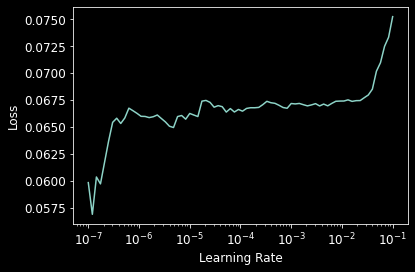

In [132]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.00010000000474974513 lrSteep: 4.786300905834651e-06


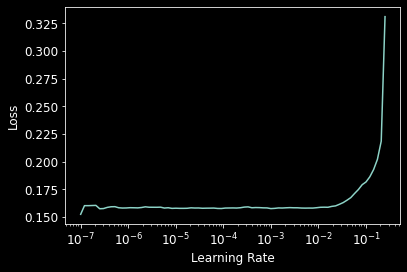

In [133]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

epoch,train_loss,valid_loss,time
0,0.067197,0.079312,00:00
1,0.066614,0.079137,00:00
2,0.066640,0.079464,00:00
3,0.066616,0.079457,00:00
4,0.066403,0.079620,00:00
5,0.066649,0.079507,00:00
6,0.066427,0.079506,00:00
7,0.066059,0.079602,00:00
8,0.066624,0.079724,00:00
9,0.066597,0.079757,00:00


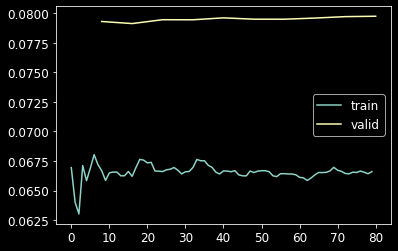

In [134]:
learn_r.fit_one_cycle(trainEpochs2_r, lr_max=lrMin_r)
learn_r.recorder.plot_loss(skip_start=0)

epoch,train_loss,valid_loss,time
0,0.159568,0.253012,00:00
1,0.159173,0.252109,00:00
2,0.159515,0.252090,00:00
3,0.158020,0.251409,00:00
4,0.157740,0.250836,00:00
5,0.157932,0.251375,00:00
6,0.157626,0.251421,00:00
7,0.157856,0.251145,00:00
8,0.157314,0.251611,00:00
9,0.156998,0.251508,00:00


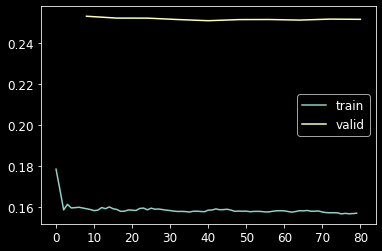

In [135]:
learn_c.fit_one_cycle(trainEpochs2_c, lr_max=lrMin_c)
learn_c.recorder.plot_loss(skip_start=0)

registered:
lrMin/10: 3.0199516913853586e-06 lrSteep: 7.585775847473997e-07


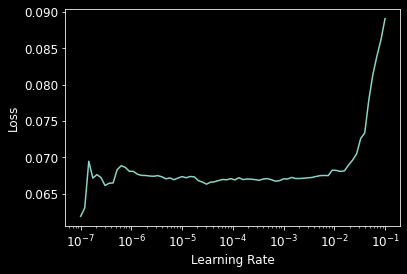

In [136]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 1.0964781722577755e-07 lrSteep: 3.981071586167673e-06


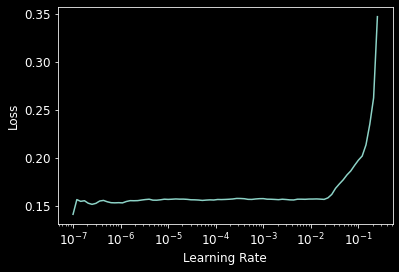

In [137]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

## Ensembling

### Validation Set

The averaging of the scores must be done in the linear state of the count variables.

In [138]:
rfPreds_r = m_r.predict(validXsFinal_r)
rfPreds_c = m_c.predict(validXsFinal_c)

nnPreds_r,nnTargs_r = learn_r.get_preds()
nnPreds_c,nnTargs_c = learn_c.get_preds()

ensPreds_r = np.log( (np.exp(to_np(nnPreds_r.squeeze())) - 1 + np.exp(rfPreds_r) - 1)/2 + 1)
ensPreds_c = np.log( (np.exp(to_np(nnPreds_c.squeeze())) - 1 + np.exp(rfPreds_c) - 1)/2 + 1)

In [139]:
print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.314271
casual final: 0.508687


In [140]:
print('Neural Network Final Results')
print('registered:', r_mse(nnPreds_r, nnTargs_r))
print('casual:    ', r_mse(nnPreds_c, nnTargs_c))

Neural Network Final Results
registered: 0.282413
casual:     0.501505


In [141]:
print('Ensembled RF/NN Final Results')
print('registered:', r_mse(ensPreds_r, validY_r))
print('casaul:    ', r_mse(ensPreds_c, validY_c))

Ensembled RF/NN Final Results
registered: 0.280206
casaul:     0.487184


An important note is that we're not averaging the errors here, we're averaging the predictions. This is why we can go from `registered` error of 0.32141 and 0.282413 for RF and NN respectively to an ensembled error of 0.282106. 

------

## Convert to `counts`

Now to get the validation error for the total `counts`, to convert my `y_r` and `y_c` into `y_total`.
$$
y_t = \log(e^{y_r} + e^{y_c} - 1)
$$

The `y` values above are `np.log(counts + 1)`.

In [142]:
print('Total count Final Results')
#print('count:', r_mse(ensPreds, y))

y_t = np.log( np.exp(y_r) + np.exp(y_c) - 1 )

y, y_t

Total count Final Results


(0        2.833213
 1        3.713572
 2        3.496508
 3        2.639057
 4        0.693147
            ...   
 10809    4.700480
 10810    4.812184
 10811    4.672829
 10812    4.499810
 10813    3.526361
 Name: count, Length: 9174, dtype: float32,
 0        2.833213
 1        3.713572
 2        3.496508
 3        2.639057
 4        0.693147
            ...   
 10809    4.700480
 10810    4.812184
 10811    4.672829
 10812    4.499810
 10813    3.526361
 Length: 9174, dtype: float32)

The original `y` aka `log(counts + 1)` are the same as `y_t` so this is how we can combine the predictions later. 

Now need to convert the predictions to an array of `counts`. Do this by exponentiating and then subtracting 1 and then summing the resulting values.

In [143]:
ensPreds = np.log( np.exp(ensPreds_r) + np.exp(ensPreds_c) - 1 )
ensPreds = np.exp(ensPreds) - 1
ensPreds

array([ 13.91721998,   8.35930766,   5.32365079, ..., 196.32546484, 147.8866623 ,  95.90891313])

Make subroutine to perform the conversion,

In [144]:
def convert_to_counts(log_r, log_c):
    counts = np.exp(log_r) + np.exp(log_c) - 2
    return counts

convert_to_counts(ensPreds_r, ensPreds_c) # test that it returns same as above

array([ 13.91721998,   8.35930766,   5.32365079, ..., 196.32546484, 147.8866623 ,  95.90891313])

## Predict test set

Do I write the predictions as `count` or as `np.log(count+1)` when submitting to Kaggle? I think `count`.

### Random Forest Predictions

Predicting the test set targets is simple, just use the `.predict()` method,

In [145]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest = convert_to_counts(rfPredsTest_r, rfPredsTest_c)

rfPredsTest

array([ 10.87747204,   6.00952043,   3.22902409, ..., 171.68715141, 116.74130189,  79.33643096])

### Neural Network Predictions

Predicting the test set with a NN is more complicated. The original dataframe that the `tabular_learner` is trained on must also contain the test set data, not be trained on the test data but it must contain the data so that the learner knows the cardinality of all columns. Then the `.dls.test_dl()` method can be used along with `.get_preds()` to calculate the predictions for the test set,

In [146]:
dlTest_r = learn_r.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_r,_ = learn_r.get_preds(dl=dlTest_r)

nnPredsTest_r = to_np( nnPredsTest_r.squeeze() )

nnPredsTest_r

array([2.3971193, 1.639676 , 1.1728032, ..., 4.9729223, 4.5332665, 4.0749583], dtype=float32)

In [147]:
dlTest_c = learn_c.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_c,_ = learn_c.get_preds(dl=dlTest_c)

nnPredsTest_c = to_np( nnPredsTest_c.squeeze() )

nnPredsTest_c

array([0.4907235 , 0.39089394, 0.25367516, ..., 2.098567  , 1.7304587 , 1.5619838 ], dtype=float32)

In [148]:
nnPredsTest = convert_to_counts(nnPredsTest_r, nnPredsTest_c)
nnPredsTest

array([ 10.624965 ,   4.6318007,   2.5197897, ..., 150.60287  ,  96.7053   ,  61.6163   ], dtype=float32)

### Ensemble Test Set Predictions

In [149]:
ensPredsTest = (rfPredsTest + nnPredsTest)/2
ensPredsTest

array([ 10.75121838,   5.32066054,   2.87440689, ..., 161.14501308, 106.72330063,  70.47636482])

------

## Create Submission File

Now we have the converted counts for random forest, neural network, and ensembled test set predictions. Recall that we previously saved the test set `datetime` column as `datetimeTest` so let's take a look at that,

### Generate datetime

In [150]:
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

Judging from the sample submission file on the Kaggle page, https://www.kaggle.com/c/bike-sharing-demand/data

The submission format for the prediction rows should be the following:
```
YYYY-MM-DD hh:mm:ss,count
```

with the first three columns (first being the header column) being:
```
datetime,count
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
```

In [151]:
print(datetimeTest[0])
print(datetimeTest[1])

2011-01-20 00:00:00
2011-01-20 01:00:00


Looks like we are good to go with the datetime column.

In [152]:
def write_submission_csv(filename, datetimeCol, predCol):
    f = open(filename, 'w')
    f.write('{},{}\n'.format('datetime', 'count'))
    for i in range(len(datetimeCol)):
        f.write('{},{}\n'.format(datetimeCol[i], predCol[i]))

### Random Forest

In [153]:
write_submission_csv('rf_submit.csv', datetimeTest, rfPredsTest)

!head rf_submit.csv

datetime,count
2011-01-20 00:00:00,10.877472040552805
2011-01-20 01:00:00,6.009520427321199
2011-01-20 02:00:00,3.229024088538581
2011-01-20 03:00:00,2.084055844287051
2011-01-20 04:00:00,1.9585303894397046
2011-01-20 05:00:00,4.291571519865119
2011-01-20 06:00:00,26.5797952782543
2011-01-20 07:00:00,82.32524429372292
2011-01-20 08:00:00,151.0855545157288


### Neural Network

In [154]:
write_submission_csv('nn_submit.csv', datetimeTest, nnPredsTest)
    
!head nn_submit.csv

datetime,count
2011-01-20 00:00:00,10.624964714050293
2011-01-20 01:00:00,4.631800651550293
2011-01-20 02:00:00,2.519789695739746
2011-01-20 03:00:00,1.7797250747680664
2011-01-20 04:00:00,1.4652817249298096
2011-01-20 05:00:00,6.252823829650879
2011-01-20 06:00:00,32.66659164428711
2011-01-20 07:00:00,85.3102798461914
2011-01-20 08:00:00,190.86183166503906


### Ensemble

In [155]:
write_submission_csv('ens_submit.csv', datetimeTest, ensPredsTest)
    
!head ens_submit.csv

datetime,count
2011-01-20 00:00:00,10.751218377301548
2011-01-20 01:00:00,5.320660539435746
2011-01-20 02:00:00,2.8744068921391634
2011-01-20 03:00:00,1.9318904595275588
2011-01-20 04:00:00,1.711906057184757
2011-01-20 05:00:00,5.272197674757999
2011-01-20 06:00:00,29.623193461270702
2011-01-20 07:00:00,83.81776206995715
2011-01-20 08:00:00,170.97369309038393
